In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.nlp import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *

from spacy.en.language_data import STOP_WORDS

# pandas and plotting config
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
nlp = spacy.load('en')

In [4]:
PATH = 'data/spooky'

os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

In [5]:
# get raw training and test datasets
train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')
sample_subm_df = pd.read_csv(f'{PATH}/sample_submission.csv')

print(f'Training size: {len(train_df)} | Test size: {len(test_df)}')
train_df.head()

Training size: 19579 | Test size: 8392


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## Feature Engineering

Add representations of the text with stopwords removed (cleaned), lemmatized, and a lemmatized version with stopwords removed.

Also add columns, that for each document, represent the percentage of various parts of speech and/or the existence of various named entities.

In [ ]:
def add_cols(df):
    rows = []
    for index, row in df.iterrows():
        cols = OrderedDict()
        
        # grab tokens, entities, and word tokens
        tokens = nlp(row['text'])
        ents = tokens.ents
        words = [ token for token in tokens if (not token.is_punct) ]
        
        # add different versions of text
        cols['cleaned_text'] = ' '.join([ t.text 
                                         for t in tokens if (not t.is_stop) and (not t.is_punct)])
        
        cols['lemmatized_text'] = ' '.join([ t.lemma_ for t in tokens ])
        
        cols['cleaned_lemmatized_text'] = ' '.join([ t.lemma_ 
                                                    for t in tokens if (not t.is_stop) and (not t.is_punct) ])
        
        # character and word counts
        cols['char_count'] = len(row['text'])
        cols['word_count'] = len(words)
        
        # ratio of token types to words
        cols['u_word_pct'] = len(set([ w.lemma_ for w in words ])) / len(words)
        cols['stopwords_pct'] = len([ w for w in words if (w.is_stop) ]) / len(words)
        cols['punctuation_pct'] = len([ t for t in tokens if (t.is_punct) ]) / len(tokens)
        cols['symbol_pct'] = len([ t for t in tokens if (t.pos_ == 'SYM') ]) / len(words)
        cols['number_pct'] = len([ t for t in tokens if (t.pos_ == 'NUM') ]) / len(words)
        cols['alpha_pct'] = len([ t for t in tokens if (t.is_alpha) ]) / len(words)
        
        cols['noun_pct'] = len([ t for t in tokens if (t.pos_ == 'NOUN') ]) / len(words)
        cols['verb_pct'] = len([ t for t in tokens if (t.pos_ == 'VERB') ]) / len(words)
        cols['adj_pct'] = len([ t for t in tokens if (t.pos_ == 'ADJ') ]) / len(words)
        cols['proper_name_pct'] = len([ t for t in tokens if (t.pos_ == 'PROPN') ]) / len(words)
    
        # ratio of named entity types
        cols['named_entity_pct'] = len(ents) / len(words)
        cols['named_entity_person_pct'] = len([ ent for ent in ents if (ent.label_ == 'PERSON') ]) / len(words)
        cols['named_entity_norp_pct'] = len([ ent for ent in ents if (ent.label_ == 'NORP') ]) / len(words)
        cols['named_entity_facility_pct'] = len([ ent for ent in ents if (ent.label_ == 'FACILITY') ]) / len(words)
        cols['named_entity_org_pct'] = len([ ent for ent in ents if (ent.label_ == 'ORG') ]) / len(words)
        cols['named_entity_gpe_pct'] = len([ ent for ent in ents if (ent.label_ == 'GPE') ]) / len(words)
        cols['named_entity_non_gpe_loc_pct'] = len([ ent for ent in ents if (ent.label_ == 'LOC') ]) / len(words)
        cols['named_entity_product_pct'] = len([ ent for ent in ents if (ent.label_ == 'PRODUCT') ]) / len(words)
        cols['named_entity_event_pct'] = len([ ent for ent in ents if (ent.label_ == 'EVENT') ]) / len(words)
        cols['named_entity_woa_pct'] = len([ ent for ent in ents if (ent.label_ == 'WORK_OF_ART') ]) / len(words)
        cols['named_entity_lang_pct'] = len([ ent for ent in ents if (ent.label_ == 'LANGUAGE') ]) / len(words)
        cols['named_entity_date_pct'] = len([ ent for ent in ents if (ent.label_ == 'DATE') ]) / len(words)
        cols['named_entity_time_pct'] = len([ ent for ent in ents if (ent.label_ == 'TIME') ]) / len(words)
        cols['named_entity_money_pct'] = len([ ent for ent in ents if (ent.label_ == 'MONEY') ]) / len(words)
        cols['named_entity_quantity_pct'] = len([ ent for ent in ents if (ent.label_ == 'QUANTITY') ]) / len(words)

        rows.append(cols)
        
    return pd.DataFrame(rows, columns=cols.keys())

In [ ]:
train_df = pd.concat([train_df, add_cols(train_df)], axis=1)
test_df = pd.concat([test_df, add_cols(test_df)], axis=1)

Add probabilites and predictions learned from sentiment analysis with pre-trained language model

In [ ]:
train_lm_results_df = pd.read_csv(f'{PATH}/20171207_2_train_preds.csv')
test_lm_results_df = pd.read_csv(f'{PATH}/20171207_2_test_preds.csv')

train_lm_results_df.drop(columns=['text', 'id', 'author'], axis=1, inplace=True)
test_lm_results_df.drop(columns=['text', 'id'], axis=1, inplace=True)

print(train_lm_results_df.shape, test_lm_results_df.shape)
train_lm_results_df.head()

In [ ]:
train_df = pd.concat([train_df, train_lm_results_df], axis=1)
test_df = pd.concat([test_df, test_lm_results_df], axis=1)

train_df.head()

In [ ]:
train_df.to_csv(f'{PATH}/train_fe_nn.csv', index=None)
test_df.to_csv(f'{PATH}/test_fe_nn.csv', index=None)

## Prepare data for ML

In [72]:
raw_train_df = pd.read_csv(f'{PATH}/train_fe_nn.csv', index_col=None)
raw_test_df = pd.read_csv(f'{PATH}/test_fe_nn.csv', index_col = None)

print(f'Avg. length of text: {np.mean(raw_train_df.text.str.len())}')
print(f'Avg. length of cleaned text: {np.mean(raw_train_df.cleaned_text.str.len())}')
print(f'Avg. length of lemma text: {np.mean(raw_train_df.lemmatized_text.str.len())}')
print(f'Avg. length of cleaned lemma text: {np.mean(raw_train_df.cleaned_lemmatized_text.str.len())}')

raw_train_df.head(2)

Avg. length of text: 149.05740844782676
Avg. length of cleaned text: 84.56477266915563
Avg. length of lemma text: 156.49261964349557
Avg. length of cleaned lemma text: 79.86534035697846


,id,text,author,cleaned_text,lemmatized_text,cleaned_lemmatized_text,char_count,word_count,u_word_pct,stopwords_pct,punctuation_pct,symbol_pct,number_pct,alpha_pct,noun_pct,verb_pct,adj_pct,proper_name_pct,named_entity_pct,named_entity_person_pct,named_entity_norp_pct,named_entity_facility_pct,named_entity_org_pct,named_entity_gpe_pct,named_entity_non_gpe_loc_pct,named_entity_product_pct,named_entity_event_pct,named_entity_woa_pct,named_entity_lang_pct,named_entity_date_pct,named_entity_time_pct,named_entity_money_pct,named_entity_quantity_pct,EAP_probs,MWS_probs,HPL_probs,EAP_preds,MWS_preds,HPL_preds
0,id26305,"This process, however, afforded me no means of...",EAP,process afforded means ascertaining dimensions...,"this process , however , afford -PRON- no mean...",process afford means ascertain dimension dunge...,231,41,0.780488,0.634146,0.145833,0.0,0.0,1.0,0.219512,0.195122,0.097561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.963837,0.003548,0.032615,3.197491,-2.407068,-0.188668
1,id17569,It never once occurred to me that the fumbling...,HPL,occurred fumbling mere mistake,-PRON- never once occur to -PRON- that the fum...,occur fumbling mere mistake,71,14,0.928571,0.714286,0.066667,0.0,0.0,1.0,0.142857,0.214286,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.431109,0.030999,0.537893,1.043664,-1.588753,1.264962


In [73]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), stop_words=STOP_WORDS,
                           min_df=0.001)

count_vec.fit(raw_train_df.cleaned_lemmatized_text.values.astype('U'))
train_ctv = count_vec.transform(raw_train_df.cleaned_lemmatized_text.values.astype('U'))
test_ctv = count_vec.transform(raw_test_df.cleaned_lemmatized_text.values.astype('U'))

print(len(count_vec.vocabulary_))
print(train_ctv.shape, test_ctv.shape)

2268
(19579, 2268) (8392, 2268)


In [74]:
train_ctv_df = pd.DataFrame(train_ctv.toarray())
test_ctv_df = pd.DataFrame(test_ctv.toarray())

train_ctv_df.shape, test_ctv_df.shape

((19579, 2268), (8392, 2268))

In [75]:
raw_train_df = pd.concat([raw_train_df, train_ctv_df], axis=1)
raw_test_df = pd.concat([raw_test_df, test_ctv_df], axis=1)

In [76]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfv = TfidfVectorizer(min_df=0.005, max_features=None, 
#             strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
#             ngram_range=(1,3), use_idf=1, smooth_idf=1, sublinear_tf=1,
#             stop_words=STOP_WORDS)

# tfv.fit(raw_train_df.cleaned_lemmatized_text.values.astype('U'))
# train_tfv = tfv.transform(raw_train_df.cleaned_lemmatized_text.values.astype('U'))
# test_tfv = tfv.transform(raw_test_df.cleaned_lemmatized_text.values.astype('U'))

# print(train_tfv.shape, test_tfv.shape)

In [77]:
# train_tfv_df = pd.DataFrame(train_tfv.toarray())
# test_tfv_df = pd.DataFrame(test_tfv.toarray())

# train_tfv.shape, test_tfv.shape

In [78]:
# raw_train_df = pd.concat([raw_train_df, train_tfv_df], axis=1)
# raw_test_df = pd.concat([raw_test_df, test_tfv_df], axis=1)

In [79]:
# label encode author
le = LabelEncoder()
raw_train_df.author = le.fit_transform(raw_train_df.author)

raw_train_df.head(2)

,id,text,author,cleaned_text,lemmatized_text,cleaned_lemmatized_text,char_count,word_count,u_word_pct,stopwords_pct,punctuation_pct,symbol_pct,number_pct,alpha_pct,noun_pct,verb_pct,adj_pct,proper_name_pct,named_entity_pct,named_entity_person_pct,named_entity_norp_pct,named_entity_facility_pct,named_entity_org_pct,named_entity_gpe_pct,named_entity_non_gpe_loc_pct,named_entity_product_pct,named_entity_event_pct,named_entity_woa_pct,named_entity_lang_pct,named_entity_date_pct,named_entity_time_pct,named_entity_money_pct,named_entity_quantity_pct,EAP_probs,MWS_probs,HPL_probs,EAP_preds,MWS_preds,HPL_preds,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,...,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,20

In [80]:
raw_train_df.columns = raw_train_df.columns.astype(str)
raw_test_df.columns = raw_test_df.columns.astype(str)

In [81]:
raw_train_df['dummy_cat'] = 1
raw_test_df['dummy_cat'] = 1

In [82]:
# list(raw_train_df.columns)

In [83]:
# 1. define categorical and continuous columns
cols_to_drop = ['text', 'cleaned_text', 'lemmatized_text', 'cleaned_lemmatized_text']
raw_train_df.drop(cols_to_drop, axis=1, inplace=True)
raw_test_df.drop(cols_to_drop, axis=1, inplace=True)

lm_vars = ['EAP_probs','MWS_probs','HPL_probs','EAP_preds','MWS_preds','HPL_preds']

cont_vars = ['char_count',
 'word_count',
 'u_word_pct',
 'stopwords_pct',
 'punctuation_pct',
 'symbol_pct',
 'number_pct',
 'alpha_pct',
 'noun_pct',
 'verb_pct',
 'adj_pct',
 'proper_name_pct',
 'named_entity_pct',
 'named_entity_person_pct',
 'named_entity_norp_pct',
 'named_entity_facility_pct',
 'named_entity_org_pct',
 'named_entity_gpe_pct',
 'named_entity_non_gpe_loc_pct',
 'named_entity_product_pct',
 'named_entity_event_pct',
 'named_entity_woa_pct',
 'named_entity_lang_pct',
 'named_entity_date_pct',
 'named_entity_time_pct',
 'named_entity_money_pct',
 'named_entity_quantity_pct']

cat_vars = list(raw_train_df.drop(['id', 'author', 'dummy_cat'] + cont_vars + lm_vars, axis=1))

target_var = 'author'
raw_test_df[target_var] = 99

# cat_vars, cont_vars, target_var

In [84]:
# 2. convert categoricals, continous, and target into correct datatypes
for v in cat_vars: 
    raw_train_df[v] = raw_train_df[v].astype('category').cat.as_ordered()
    
for v in cont_vars: 
    raw_train_df[v] = raw_train_df[v].astype(np.float32)
    raw_test_df[v] = raw_test_df[v].astype(np.float32)
    
raw_train_df.head(2)

,id,author,char_count,word_count,u_word_pct,stopwords_pct,punctuation_pct,symbol_pct,number_pct,alpha_pct,noun_pct,verb_pct,adj_pct,proper_name_pct,named_entity_pct,named_entity_person_pct,named_entity_norp_pct,named_entity_facility_pct,named_entity_org_pct,named_entity_gpe_pct,named_entity_non_gpe_loc_pct,named_entity_product_pct,named_entity_event_pct,named_entity_woa_pct,named_entity_lang_pct,named_entity_date_pct,named_entity_time_pct,named_entity_money_pct,named_entity_quantity_pct,EAP_probs,MWS_probs,HPL_probs,EAP_preds,MWS_preds,HPL_preds,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,...,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107

In [85]:
apply_cats(raw_test_df, raw_train_df)

In [86]:
# mapper not returned because we have no continuous vars and so no scaling!
train_df, y, nas, mapper = proc_df(raw_train_df, target_var, do_scale=True, skip_flds=['id'])

n = len(train_df); print(n, len(y), nas, len(mapper.features))
train_df.head(2)

19579 19579 {} 34


,char_count,word_count,u_word_pct,stopwords_pct,punctuation_pct,symbol_pct,number_pct,alpha_pct,noun_pct,verb_pct,adj_pct,proper_name_pct,named_entity_pct,named_entity_person_pct,named_entity_norp_pct,named_entity_facility_pct,named_entity_org_pct,named_entity_gpe_pct,named_entity_non_gpe_loc_pct,named_entity_product_pct,named_entity_event_pct,named_entity_woa_pct,named_entity_lang_pct,named_entity_date_pct,named_entity_time_pct,named_entity_money_pct,named_entity_quantity_pct,EAP_probs,MWS_probs,HPL_probs,EAP_preds,MWS_preds,HPL_preds,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,...,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2

In [87]:
test_df, _, nas, mapper = proc_df(raw_test_df, target_var, do_scale=True, skip_flds=['id'],
                                  mapper=mapper, na_dict=nas)

In [88]:
val_idxs = get_cv_idxs(n)
len(val_idxs)

3915

In [89]:
# y = pd.get_dummies(raw_train_df.author).as_matrix()

In [90]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs, train_df, y.astype(np.int64), cat_flds=cat_vars, bs=64, test_df=test_df)

In [91]:
cat_szs = [ (v, len(raw_train_df[v].cat.categories) + 1) for v in cat_vars ]
cat_szs

[('0', 3),
 ('1', 5),
 ('2', 4),
 ('3', 4),
 ('4', 3),
 ('5', 3),
 ('6', 3),
 ('7', 3),
 ('8', 4),
 ('9', 4),
 ('10', 3),
 ('11', 5),
 ('12', 3),
 ('13', 3),
 ('14', 3),
 ('15', 3),
 ('16', 4),
 ('17', 3),
 ('18', 3),
 ('19', 4),
 ('20', 3),
 ('21', 3),
 ('22', 3),
 ('23', 3),
 ('24', 3),
 ('25', 3),
 ('26', 4),
 ('27', 4),
 ('28', 4),
 ('29', 3),
 ('30', 3),
 ('31', 3),
 ('32', 3),
 ('33', 3),
 ('34', 3),
 ('35', 4),
 ('36', 4),
 ('37', 3),
 ('38', 3),
 ('39', 3),
 ('40', 3),
 ('41', 3),
 ('42', 4),
 ('43', 4),
 ('44', 3),
 ('45', 3),
 ('46', 4),
 ('47', 4),
 ('48', 3),
 ('49', 4),
 ('50', 4),
 ('51', 3),
 ('52', 3),
 ('53', 4),
 ('54', 3),
 ('55', 3),
 ('56', 4),
 ('57', 5),
 ('58', 3),
 ('59', 4),
 ('60', 4),
 ('61', 3),
 ('62', 5),
 ('63', 3),
 ('64', 3),
 ('65', 3),
 ('66', 4),
 ('67', 4),
 ('68', 4),
 ('69', 3),
 ('70', 5),
 ('71', 4),
 ('72', 4),
 ('73', 3),
 ('74', 3),
 ('75', 3),
 ('76', 3),
 ('77', 4),
 ('78', 4),
 ('79', 3),
 ('80', 4),
 ('81', 3),
 ('82', 3),
 ('83', 3),
 (

In [102]:
emb_szs = [ (csz, min(50, (csz+1) // 2)) for _, csz in cat_szs ]
emb_szs

[(3, 40),
 (5, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (5, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (5, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (5, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (5, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (4, 40),
 (4, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (4, 40),
 (5, 40),
 (3, 40),
 (3, 40),
 (4, 40),
 (4, 40),
 (5, 40),


In [103]:
learner = md.get_learner(emb_szs, len(train_df.columns)-len(cat_vars), 
                         0.04, 3, [1000, 500], [0.001, 0.01], y_range=None)
learner.crit = F.cross_entropy

In [104]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 51%|█████     | 125/245 [02:34<02:28,  1.24s/it, loss=6.98]

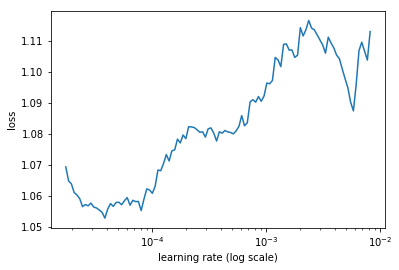

In [105]:
learner.sched.plot()

In [96]:
lr = 1e-4

In [97]:
learner.fit(lr, 3, wds=0.025, use_wd_sched=True, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  1%|          | 3/245 [00:01<01:44,  2.33it/s, loss=1.13]  

Exception in thread Thread-54:
Traceback (most recent call last):
  File "/home/wgilliam/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/wgilliam/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/wgilliam/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-55:
Traceback (most recent call last):
  File "/home/wgilliam/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/wgilliam/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/wgilliam/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set chang

[ 0.       0.70821  0.71601]                                 
[ 1.       0.53672  0.57023]                                 
[ 2.       0.44316  0.50746]                                 



In [98]:
learner.fit(lrs=lr, n_cycle=1, wds=0.025, use_wd_sched=True, cycle_len=10)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.      0.3994  0.4469]                                    
[ 1.       0.36307  0.49162]                                 
[ 2.       0.3583   0.44219]                                 
[ 3.       0.34165  0.43816]                                 
[ 4.       0.33896  0.44214]                                 
[ 5.       0.33064  0.4419 ]                                 
[ 6.       0.33674  0.43857]                                 
[ 7.       0.33408  0.43728]                                 
[ 8.       0.32759  0.43747]                                 
[ 9.       0.32174  0.43737]                                 



### Evaluate

In [32]:
preds, actuals = learner.predict_with_targs()

In [33]:
preds.shape, accuracy(preds,actuals)

((3915, 3), 0.82630906768837808)

In [34]:
# F.mse_loss(V(preds), V(actuals))

In [35]:
preds[:10], actuals[:10]

(array([[ 5.47699, -1.96094, -7.21659],
        [-5.62209, -4.54167,  7.40075],
        [ 3.96986, -2.71649, -5.24264],
        [-1.09443, -6.69177,  5.08945],
        [-7.20318,  9.85962, -9.95179],
        [-5.36024, -2.19924,  4.79571],
        [-1.93583,  5.09278, -6.94016],
        [-4.76216,  4.25212, -4.74073],
        [-4.12871,  6.11173, -6.54396],
        [-6.3371 ,  9.11142, -9.13469]], dtype=float32),
 array([0, 2, 0, 2, 1, 2, 1, 1, 1, 1]))

In [36]:
F.softmax(V(preds[:10]))

Variable containing:
 9.9941e-01  5.8815e-04  3.0689e-06
 2.2093e-06  6.5083e-06  9.9999e-01
 9.9865e-01  1.2462e-03  9.9651e-05
 2.0582e-03  7.6310e-06  9.9793e-01
 3.8879e-08  1.0000e+00  2.4889e-09
 3.8807e-05  9.1562e-04  9.9905e-01
 8.8537e-04  9.9911e-01  5.9398e-06
 1.2163e-04  9.9975e-01  1.2427e-04
 3.5696e-05  9.9996e-01  3.1892e-06
 1.9534e-07  1.0000e+00  1.1907e-08
[torch.FloatTensor of size 10x3]

Make predictions on Test

In [37]:
preds, _ = learner.predict_with_targs(True)

In [38]:
preds[:10]

array([[ -4.67944,  -2.88946,   5.79034],
       [ 10.71458,  -9.19936,  -7.4041 ],
       [ -4.84429,   4.70314,  -3.55918],
       [  2.4615 ,  -0.54976,  -3.53602],
       [  1.62345,  -1.55026,  -1.08261],
       [  8.20525,  -3.20243, -10.71883],
       [  5.05741,  -4.05135,  -3.73883],
       [ -6.41583,   5.9827 ,  -4.70839],
       [  7.96884,  -8.00696,  -3.72576],
       [  3.7284 ,  -6.03603,  -0.14797]], dtype=float32)

In [39]:
F.softmax(V(preds[:10]))

Variable containing:
 2.8376e-05  1.6995e-04  9.9980e-01
 1.0000e+00  2.2464e-09  1.3526e-08
 7.1361e-05  9.9967e-01  2.5798e-04
 9.5083e-01  4.6809e-02  2.3627e-03
 9.0200e-01  3.7747e-02  6.0253e-02
 9.9999e-01  1.1110e-05  6.0446e-09
 9.9974e-01  1.1066e-04  1.5126e-04
 4.1245e-06  9.9997e-01  2.2746e-05
 9.9999e-01  1.1529e-07  8.3387e-06
 9.7964e-01  5.6289e-05  2.0304e-02
[torch.FloatTensor of size 10x3]